In [22]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [23]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [24]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [25]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
print(len(bbox_files))

3685


In [26]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제, xml도 같이 삭제
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    bbox_file = os.path.splitext(image_file)[0]+'.xml'
    bbox_path = os.path.join(bbox_dir, bbox_file)
    image = Image.open(image_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(image_file, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(image_path)
        try:
            os.remove(bbox_path)
        except FileNotFoundError:
            pass

In [27]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [28]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
print(len(bbox_files))

3685


In [29]:
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [30]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [31]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [32]:
bbox_files[:20]

['Abyssinian_1.xml',
 'Abyssinian_10.xml',
 'Abyssinian_100.xml',
 'Abyssinian_101.xml',
 'Abyssinian_102.xml',
 'Abyssinian_103.xml',
 'Abyssinian_105.xml',
 'Abyssinian_106.xml',
 'Abyssinian_107.xml',
 'Abyssinian_108.xml',
 'Abyssinian_109.xml',
 'Abyssinian_11.xml',
 'Abyssinian_110.xml',
 'Abyssinian_111.xml',
 'Abyssinian_112.xml',
 'Abyssinian_113.xml',
 'Abyssinian_114.xml',
 'Abyssinian_115.xml',
 'Abyssinian_116.xml',
 'Abyssinian_117.xml']

In [33]:
IMG_SIZE = 224
N_BBOX = len(bbox_files)
N_TRAIN = 3000
N_VAL = N_BBOX - N_TRAIN

In [34]:
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(data_dir, 'loc_train.tfr')
tfr_val_dir = os.path.join(data_dir, 'loc_val.tfr')

In [35]:
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [36]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [37]:
shuffle_list = list(range(N_BBOX))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [38]:
shuffle_list

[2819,
 671,
 2405,
 1682,
 3136,
 245,
 2989,
 3504,
 2855,
 1304,
 1202,
 1393,
 1198,
 2993,
 1361,
 62,
 2630,
 1389,
 1892,
 59,
 2298,
 3503,
 618,
 3445,
 2938,
 2250,
 2881,
 2924,
 2166,
 956,
 1659,
 1117,
 122,
 1161,
 10,
 1585,
 254,
 1298,
 1800,
 3523,
 1853,
 748,
 629,
 2216,
 188,
 645,
 296,
 3514,
 2865,
 799,
 1953,
 2158,
 1881,
 3381,
 3374,
 1205,
 223,
 2059,
 2153,
 96,
 1231,
 323,
 1286,
 2248,
 1818,
 2300,
 2342,
 413,
 3052,
 1093,
 2714,
 2598,
 786,
 108,
 772,
 2371,
 355,
 2407,
 792,
 3150,
 3104,
 3049,
 2009,
 1024,
 1607,
 1072,
 487,
 3037,
 631,
 1062,
 1006,
 699,
 1548,
 287,
 2221,
 701,
 2169,
 2412,
 752,
 3384,
 306,
 638,
 1312,
 2230,
 1869,
 2409,
 35,
 340,
 1828,
 1935,
 3219,
 2574,
 3185,
 366,
 3266,
 1094,
 455,
 550,
 2033,
 1793,
 2435,
 2668,
 857,
 1194,
 698,
 2628,
 3275,
 3391,
 918,
 1040,
 1971,
 1083,
 2108,
 1917,
 2315,
 705,
 1782,
 141,
 2473,
 2911,
 2786,
 1817,
 941,
 2247,
 781,
 1955,
 1146,
 2966,
 205,
 2757,


In [39]:
for idx in train_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
    
    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height
    
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
    
    if file_name[0].islower(): # dog
        bi_cls_num = 0
    else: # cat
        bi_cls_num = 1
        
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num),
        'bi_cls_num': _int64_feature(bi_cls_num),
        'x': _float_feature(x),
        'y': _float_feature(y),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))
    writer_train.write(example.SerializeToString())

writer_train.close()

In [42]:
for idx in val_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
    
    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height
    
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
    
    if file_name[0].islower(): # dog
        bi_cls_num = 0
    else: # cat
        bi_cls_num = 1
        
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num),
        'bi_cls_num': _int64_feature(bi_cls_num),
        'x': _float_feature(x),
        'y': _float_feature(y),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))
    writer_val.write(example.SerializeToString())

writer_val.close()

In [43]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 40
N_BATCH = 40
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [47]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32) / 255. 

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [48]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [49]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

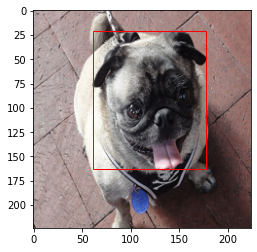

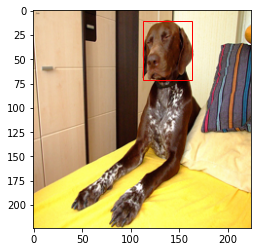

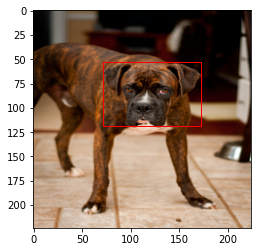

In [51]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(3):
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고,
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE) 
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

In [55]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4, activation='sigmoid'))
    return model

In [56]:
def loss_fn(y_true, y_pred):
    return keras.losses.MeanSquaredError()(y_true, y_pred)

In [57]:
## create model, comile & summary
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 128)     

In [59]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(keras.optimizers.RMSprop(lr_schedule), loss=loss_fn)


In [60]:
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/40
75/75 [==============================] - 26s 238ms/step - loss: 0.0241 - val_loss: 0.0232
Epoch 2/40
75/75 [==============================] - 14s 179ms/step - loss: 0.0221 - val_loss: 0.0202
Epoch 3/40
75/75 [==============================] - 15s 187ms/step - loss: 0.0198 - val_loss: 0.0191
Epoch 4/40
75/75 [==============================] - 14s 183ms/step - loss: 0.0183 - val_loss: 0.0184
Epoch 5/40
75/75 [==============================] - 14s 180ms/step - loss: 0.0167 - val_loss: 0.0171
Epoch 6/40
75/75 [==============================] - 15s 187ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 7/40
75/75 [==============================] - 15s 185ms/step - loss: 0.0140 - val_loss: 0.0157
Epoch 8/40
75/75 [==============================] - 15s 185ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 9/40
75/75 [==============================] - 15s 193ms/step - loss: 0.0117 - val_loss: 0.0144
Epoch 10/40
75/75 [==============================] - 15s 189ms/step - loss: 0.0107 - val_lo

2/2 [==============================] - 1s 332ms/step


<ipython-input-61-e2509738a983>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().add_patch(pred_rect)


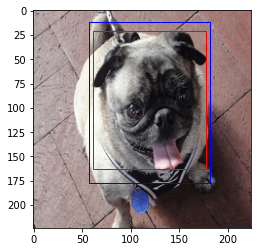

2/2 [==============================] - 0s 44ms/step


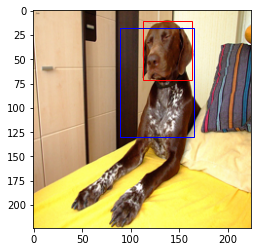

2/2 [==============================] - 0s 47ms/step


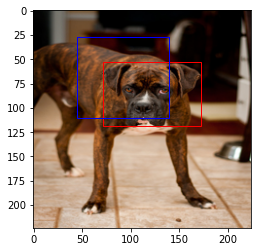

2/2 [==============================] - 0s 47ms/step


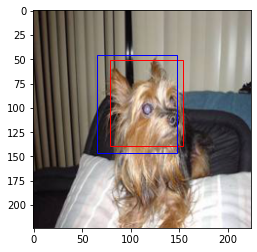

2/2 [==============================] - 0s 48ms/step


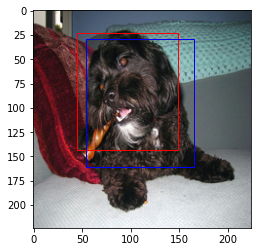

2/2 [==============================] - 0s 49ms/step


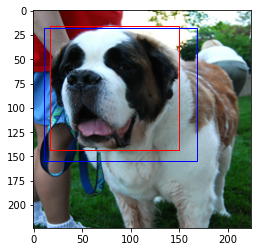

2/2 [==============================] - 0s 46ms/step


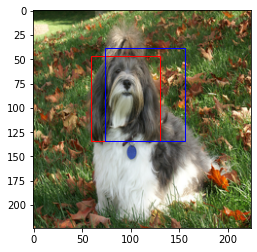

2/2 [==============================] - 0s 55ms/step


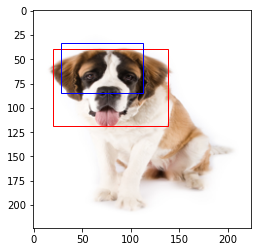

2/2 [==============================] - 0s 47ms/step


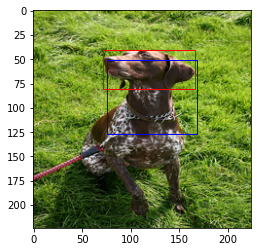

2/2 [==============================] - 0s 47ms/step


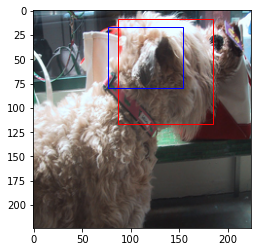

2/2 [==============================] - 0s 48ms/step


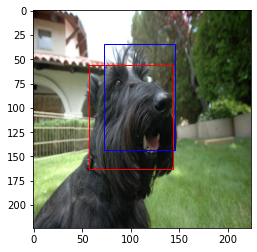

2/2 [==============================] - 0s 49ms/step


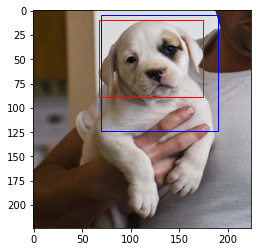

2/2 [==============================] - 0s 49ms/step


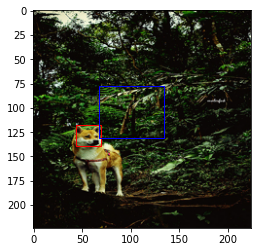

2/2 [==============================] - 0s 47ms/step


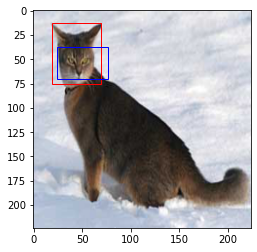

2/2 [==============================] - 0s 46ms/step


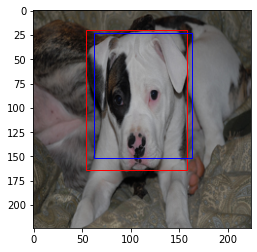

2/2 [==============================] - 0s 48ms/step


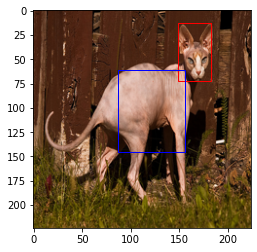

2/2 [==============================] - 0s 45ms/step


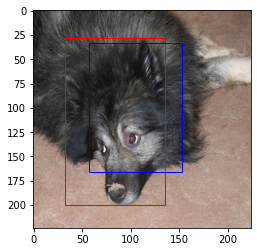

1/1 [==============================] - 0s 20ms/step


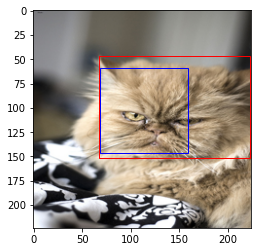

In [61]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE) 
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE) 
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h, 
                          fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    plt.imshow(val_data[idx])
    plt.show()

In [62]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    ## 정답 box 그리기
    flag = (i == validation_steps-1)
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_BATCH):
        if(flag):
            if idx == res:
                flag = False
                break
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        pred_xmin = int((pred_x[idx] - w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + h[idx]/2.)*IMG_SIZE)
        
        if xmin > pred_xmax or xmax < pred_xmin:
            continue
        if ymin > pred_ymax or ymax < pred_ymin:
            continue
        w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
        h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
  
        w_sub1 = np.abs(xmax - pred_xmax)
        h_sub1 = np.abs(ymax - pred_ymax)
        w_sub2 = np.abs(xmin - pred_xmin)
        h_sub2 = np.abs(ymin - pred_ymin)
        
        iou = (w_inter * h_inter) / ((w_union * h_union) - (w_sub1 * h_sub1) - (w_sub2 * h_sub2))
        avg_iou += iou / N_VAL
        
print(avg_iou)

1/1 [==============================] - 0s 19ms/step
0.5727180279935095
